In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy, scipy as sklearn, librosa, urllib
import librosa.display
from IPython.display import Audio
import json 
import seaborn as sns
from sklearn.cluster import KMeans
import csv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling1D, Flatten, Dropout, BatchNormalization,Softmax, GlobalAveragePooling2D,GlobalMaxPooling2D
from sklearn.decomposition import PCA
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import EarlyStopping
from itertools import cycle
from sklearn.manifold import TSNE
from sklearn.metrics import roc_curve, auc, silhouette_score,roc_auc_score, precision_recall_fscore_support

In [3]:
#read the pickle files
not_aug_df=pd.read_pickle('EMOVO_dataset/not_aug_df.pkl')
semi_aug_df=pd.read_pickle('EMOVO_dataset/semi_aug_df.pkl')
aug_df=pd.read_pickle('EMOVO_dataset/aug_df.pkl')

In [4]:
#creation of the array containg the emotions ordered by their encoding
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
sorted_labels=[]
label_encoder.fit(not_aug_df['label'])
name_mapping = dict(zip( label_encoder.transform(label_encoder.classes_),label_encoder.classes_))
for i in range(7):
  sorted_labels.append(name_mapping[i])
sorted_labels

['anger', 'disgust', 'fear', 'joy', 'neutrality', 'sadness', 'surprise']

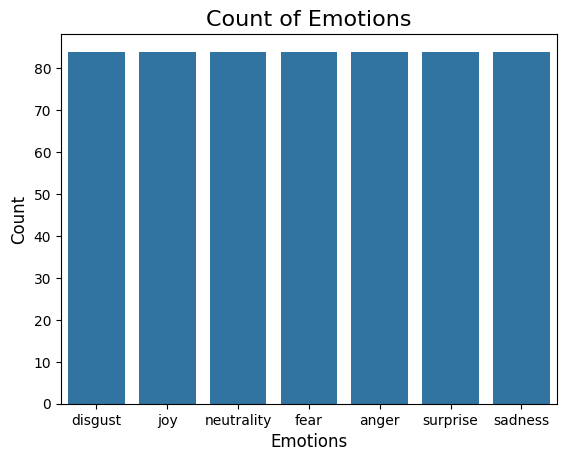

In [5]:
#ahow class balance
plt.title('Count of Emotions', size=16)
sns.countplot(x= not_aug_df['label'])
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.show()

In [6]:
scaler = StandardScaler()

In [7]:
#extraction of the mfccs from the datasets - not aug
X_mfccs_k = np.array(not_aug_df.iloc[:, 3:29])
X_mfccs_k=np.array(X_mfccs_k.tolist())
X_mfccs_k=scaler.fit_transform(X_mfccs_k.reshape(-1, X_mfccs_k.shape[-1])).reshape(X_mfccs_k.shape)
Y_mfccs_k=not_aug_df['label']

In [8]:
#extraction of the log mel specrogram from the datasets - not aug
X_logmel_k = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel_k=np.array(X_logmel_k.tolist())
X_logmel_k=scaler.fit_transform(X_logmel_k.reshape(-1, X_logmel_k.shape[-1])).reshape(X_logmel_k.shape)
Y_logmel_k=not_aug_df['label']

In [9]:
#reshape the data from 3D to 2D - not aug
X_mfccs_k=X_mfccs_k.reshape(X_mfccs_k.shape[0],X_mfccs_k.shape[1]*X_mfccs_k.shape[2])
X_logmel_k=X_logmel_k.reshape(X_logmel_k.shape[0],X_logmel_k.shape[1]*X_logmel_k.shape[2])


# Models

In [11]:
#extraction of labels_id from datasets
Y_not_aug=not_aug_df['label_id']
Y_semi_aug=semi_aug_df['label_id']
Y_aug=aug_df['label_id']


In [12]:
#take the log mel spectrogram from the datasets
X_logmel = np.array(not_aug_df.loc[:, ['logmel' in i for i in not_aug_df.columns]])
X_logmel=np.array(X_logmel.tolist())
X_logmel_semi_aug = np.array(semi_aug_df.loc[:, ['logmel' in i for i in semi_aug_df.columns]])
X_logmel_semi_aug=np.array(X_logmel_semi_aug.tolist())
X_logmel_aug = np.array(aug_df.loc[:, ['logmel' in i for i in aug_df.columns]])
X_logmel_aug=np.array(X_logmel_aug.tolist())

In [13]:
#take the mfccs & deltas from the datasets
X_mfccs = np.array(not_aug_df.iloc[:, 3:29]) 
X_mfccs=np.array(X_mfccs.tolist())
X_mfccs_semi_aug = np.array(semi_aug_df.iloc[:, 3:29])
X_mfccs_semi_aug=np.array(X_mfccs_semi_aug.tolist())
X_mfccs_aug = np.array(aug_df.iloc[:, 3:29])
X_mfccs_aug=np.array(X_mfccs_aug.tolist())

## kfold

In [14]:
#create the  stratified k-fold generator of test and training data
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
generator = StratifiedShuffleSplit(n_splits=10)

In [15]:
#function for the creation of the confusion matrix
def create_confusion_matrix(confusion_matrix):
    labels=sorted_labels
    column= [f'predicted {label}'for label in labels]
    indeces=  [f'true {label}'
               for label in labels]
    matrix= pd.DataFrame(data=confusion_matrix,columns=column, index=indeces )
    return sns.heatmap(matrix, annot=True, fmt='d', cmap="YlGnBu")

In [16]:
#function used to create the ROC curve
def create_general_roc_curve(fpr, tpr):
  colors = cycle(["aqua", "red", "blue","green","yellow","orange","purple"])
  for i, color,label in zip(range(7), colors, sorted_labels):
    plt.plot( 
        [0,fpr[i],1],
        [0,tpr[i],1],
        color=color,
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(label,auc([0,fpr[i],1],[0, tpr[i],1]) ),
    )

  plt.plot([0, 1], [0, 1], "k--", lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.legend(loc="lower right")
  plt.show()

In [17]:
def calculate_scores(conf_mat):
  precisions=dict.fromkeys([0,1,2,3,4,5,6])
  recalls=dict.fromkeys([0,1,2,3,4,5,6])
  f1s=dict.fromkeys([0,1,2,3,4,5,6])
  fpr=dict.fromkeys([0,1,2,3,4,5,6])
  for i in range(7):
    tp=conf_mat[i][i]
    sum_fp=0
    for z in [x for x in range(7) if x != i]:
      sum_fp+= conf_mat[z][i]
    fp=sum_fp
    precision=tp/(tp+fp)
    precisions[i]=precision
    sum_fn=0
    for z in [x for x in range(7) if x != i]:
      sum_fn+=conf_mat[i][z]
    fn=sum_fn
    recall=tp/(tp+fn)
    recalls[i]=recall
    f1=2*(precision*recall)/(precision+recall)
    f1s[i]=f1
    sum_tn=0
    for z in [x for x in range(7) if x != i]:
      sum_tn+=conf_mat[z][z]
    fpr[i]=fp/(fp+sum_tn)
  return precisions,recalls,f1s,fpr

In [18]:
#add one dimension to data to make them suitable foR CNN
X_logmel = np.reshape(X_logmel, (X_logmel.shape[0],X_logmel.shape[1],X_logmel.shape[2],1))
X_logmel_semi_aug= np.reshape(X_logmel_semi_aug, (X_logmel_semi_aug.shape[0],X_logmel_semi_aug.shape[1],X_logmel_semi_aug.shape[2],1))
X_logmel_aug= np.reshape(X_logmel_aug, (X_logmel_aug.shape[0],X_logmel_aug.shape[1],X_logmel_aug.shape[2],1))

In [19]:
#CNN creation
def create_cnn(input_data):
  modelcnn = keras.Sequential()


  modelcnn.add(keras.layers.Conv2D(32, (2, 6), activation='relu', input_shape=input_data,kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7), strides=(2,2),padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))
  
  modelcnn.add(keras.layers.Conv2D(64, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2,7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(128, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))


  modelcnn.add(keras.layers.Conv2D(256, (2, 6), activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.MaxPooling2D((2, 7),strides=(2,2), padding='same'))
  modelcnn.add(keras.layers.Dropout(rate=0.3))

 
  modelcnn.add(keras.layers.GlobalAveragePooling2D())
  modelcnn.add(keras.layers.Dense(128, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))
  modelcnn.add(keras.layers.Dense(256, activation='relu',kernel_regularizer=keras.regularizers.l2(0.001)))
  modelcnn.add(keras.layers.Dropout(0.3))

  modelcnn.add(keras.layers.Dense(7, activation='softmax'))
  
  return modelcnn

### CNN

#### vanilla dataset

In [20]:
input_data=(X_logmel.shape[1:])
histories_cnn = []
confusion_matrices_cnn=[]
results_cnn=[]
actual_labels_cnn=np.array([])
predicted_labels_cnn=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_logmel, Y_not_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
            # get the training and test data
            train_X, test_X = X_logmel[train_indices], X_logmel[test_indices]
            train_y, test_y = Y_not_aug[train_indices], Y_not_aug[test_indices]
            actual_labels_cnn=np.append(actual_labels_cnn,test_y)
            #normalize the data
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
            test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
            print(train_X.shape)
            modelcnn=create_cnn(input_data)
            modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=256,epochs=1000,callbacks=[EarlyStopping(patience=10,monitor="loss")])
            histories_cnn.append(history)
            pred=modelcnn.predict(test_X)
            pred=pred.argmax(axis=1)
            predicted_labels_cnn=np.append(predicted_labels_cnn,pred)
            conf_matr=confusion_matrix(test_y,pred)
            confusion_matrices_cnn.append(conf_matr)
            results = modelcnn.evaluate(test_X, test_y, batch_size=128)
            results_cnn.append(results)
            
            

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(529, 60, 130, 1)
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 340ms/step - accuracy: 0.1278 - loss: 2.6953 - val_accuracy: 0.1525 - val_loss: 2.5722
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1637 - loss: 2.5757 - val_accuracy: 0.1695 - val_loss: 2.5555
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.1935 - loss: 2.5391 - val_accuracy: 0.1695 - val_loss: 2.5365
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.2046 - loss: 2.5070 - val_accuracy: 0.2034 - val_loss: 2.5123
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.2468 - loss: 2.4574 - val_accuracy: 0.2034 - val_loss: 2.4820
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.2570 - loss: 2.4007 - val_accuracy: 0.1864 - val_loss: 2.4615
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.2131 - loss: 2.4180 - val_accuracy: 0.1695 - val_loss: 2.4511
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.2052 - loss: 2.3908 

Computing k-fold:  10%|█         | 1/10 [01:19<11:58, 79.87s/it]c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(529, 60, 130, 1)
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.1533 - loss: 2.6652 - val_accuracy: 0.1525 - val_loss: 2.5756
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 225ms/step - accuracy: 0.1147 - loss: 2.5924 - val_accuracy: 0.1695 - val_loss: 2.5580
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.1581 - loss: 2.5537 - val_accuracy: 0.1695 - val_loss: 2.5395
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.1787 - loss: 2.5312 - val_accuracy: 0.2542 - val_loss: 2.5197
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1926 - loss: 2.5077 - val_accuracy: 0.2373 - val_loss: 2.4999
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy: 0.2133 - loss: 2.4640 - val_accuracy: 0.1695 - val_loss: 2.4809
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.2128 - loss: 2.4312 - val_accuracy: 0.2203 - val_loss: 2.4495
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.2306 - loss: 2.4069 

Computing k-fold:  20%|██        | 2/10 [04:02<17:09, 128.73s/it]c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(529, 60, 130, 1)
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 335ms/step - accuracy: 0.1710 - loss: 2.6837 - val_accuracy: 0.1356 - val_loss: 2.5677
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 0.1604 - loss: 2.5710 - val_accuracy: 0.1525 - val_loss: 2.5511
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.1801 - loss: 2.5496 - val_accuracy: 0.1864 - val_loss: 2.5332
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.1687 - loss: 2.5262 - val_accuracy: 0.1864 - val_loss: 2.5137
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 287ms/step - accuracy: 0.1873 - loss: 2.5067 - val_accuracy: 0.1864 - val_loss: 2.4922
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step - accuracy: 0.2079 - loss: 2.4804 - val_accuracy: 0.1864 - val_loss: 2.4665
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.2037 - loss: 2.4396 - val_accuracy: 0.2034 - val_loss: 2.4397
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.2037 - loss: 2.4512 

Computing k-fold:  30%|███       | 3/10 [05:45<13:38, 116.87s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.1344 - loss: 2.6575 - val_accuracy: 0.1356 - val_loss: 2.5722
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1397 - loss: 2.5858 - val_accuracy: 0.1695 - val_loss: 2.5542
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.1575 - loss: 2.5492 - val_accuracy: 0.1356 - val_loss: 2.5341
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.1585 - loss: 2.5276 - val_accuracy: 0.1525 - val_loss: 2.5127
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1954 - loss: 2.5028 - val_accuracy: 0.1695 - val_loss: 2.4895
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.2247 - loss: 2.4569 - val_accuracy: 0.2203 - val_loss: 2.4583
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.2595 - loss: 2.4061 - val_accuracy: 0.1525 - val_loss: 2.4349
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.1959 - loss: 2.4105 - val_accuracy: 0.

Computing k-fold:  40%|████      | 4/10 [07:23<10:56, 109.43s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.1730 - loss: 2.6511 - val_accuracy: 0.1525 - val_loss: 2.5698
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 235ms/step - accuracy: 0.1603 - loss: 2.5755 - val_accuracy: 0.1356 - val_loss: 2.5526
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - accuracy: 0.1464 - loss: 2.5520 - val_accuracy: 0.1864 - val_loss: 2.5332
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1638 - loss: 2.5294 - val_accuracy: 0.2034 - val_loss: 2.5146
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 209ms/step - accuracy: 0.1973 - loss: 2.4935 - val_accuracy: 0.1695 - val_loss: 2.4913
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.1858 - loss: 2.4639 - val_accuracy: 0.2034 - val_loss: 2.4587
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.2219 - loss: 2.4026 - val_accuracy: 0.2542 - val_loss: 2.4088
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.2335 - loss: 2.3657 - val_accuracy: 0.

Computing k-fold:  50%|█████     | 5/10 [10:57<12:14, 146.97s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.1231 - loss: 2.7055 - val_accuracy: 0.1695 - val_loss: 2.5725
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1475 - loss: 2.5920 - val_accuracy: 0.1525 - val_loss: 2.5576
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.1532 - loss: 2.5590 - val_accuracy: 0.1695 - val_loss: 2.5416
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1723 - loss: 2.5346 - val_accuracy: 0.1695 - val_loss: 2.5238
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.2158 - loss: 2.5079 - val_accuracy: 0.2373 - val_loss: 2.5027
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.2239 - loss: 2.4745 - val_accuracy: 0.2034 - val_loss: 2.4778
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step - accuracy: 0.2050 - loss: 2.4559 - val_accuracy: 0.2203 - val_loss: 2.4502
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.2420 - loss: 2.4032 - val_accuracy: 0.

Computing k-fold:  60%|██████    | 6/10 [12:14<08:13, 123.46s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 342ms/step - accuracy: 0.1513 - loss: 2.6546 - val_accuracy: 0.1525 - val_loss: 2.5697
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1344 - loss: 2.5839 - val_accuracy: 0.1356 - val_loss: 2.5525
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.1537 - loss: 2.5458 - val_accuracy: 0.1356 - val_loss: 2.5335
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step - accuracy: 0.1692 - loss: 2.5332 - val_accuracy: 0.1356 - val_loss: 2.5138
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.1526 - loss: 2.5079 - val_accuracy: 0.1356 - val_loss: 2.4926
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.1825 - loss: 2.4787 - val_accuracy: 0.1525 - val_loss: 2.4734
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.1945 - loss: 2.4444 - val_accuracy: 0.1525 - val_loss: 2.4547
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.1964 - loss: 2.4184 - val_accuracy: 0.

Computing k-fold:  70%|███████   | 7/10 [13:35<05:28, 109.37s/it]c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(529, 60, 130, 1)
Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - accuracy: 0.1388 - loss: 2.6383 - val_accuracy: 0.1356 - val_loss: 2.5706
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.1624 - loss: 2.5831 - val_accuracy: 0.1356 - val_loss: 2.5514
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 216ms/step - accuracy: 0.1815 - loss: 2.5577 - val_accuracy: 0.2373 - val_loss: 2.5316
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.1662 - loss: 2.5305 - val_accuracy: 0.2542 - val_loss: 2.5113
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.1576 - loss: 2.5053 - val_accuracy: 0.1695 - val_loss: 2.4882
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1828 - loss: 2.4761 - val_accuracy: 0.2881 - val_loss: 2.4547
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.2013 - loss: 2.4427 - val_accuracy: 0.2712 - val_loss: 2.4099
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step - accuracy: 0.2504 - loss: 2.3792 

Computing k-fold:  80%|████████  | 8/10 [15:25<03:39, 109.78s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 319ms/step - accuracy: 0.1456 - loss: 2.6499 - val_accuracy: 0.1356 - val_loss: 2.5730
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.1571 - loss: 2.5753 - val_accuracy: 0.2542 - val_loss: 2.5487
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.1782 - loss: 2.5455 - val_accuracy: 0.2712 - val_loss: 2.5252
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.1975 - loss: 2.5032 - val_accuracy: 0.2542 - val_loss: 2.4980
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 215ms/step - accuracy: 0.2074 - loss: 2.4724 - val_accuracy: 0.2034 - val_loss: 2.4511
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.2027 - loss: 2.4496 - val_accuracy: 0.2373 - val_loss: 2.4049
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 259ms/step - accuracy: 0.2362 - loss: 2.4497 - val_accuracy: 0.2712 - val_loss: 2.3819
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.2224 - loss: 2.3915 - val_accuracy: 0.

Computing k-fold:  90%|█████████ | 9/10 [18:06<02:05, 125.61s/it]

(529, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 321ms/step - accuracy: 0.1205 - loss: 2.6554 - val_accuracy: 0.1356 - val_loss: 2.5715
Epoch 2/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.1478 - loss: 2.5783 - val_accuracy: 0.1525 - val_loss: 2.5549
Epoch 3/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 214ms/step - accuracy: 0.1416 - loss: 2.5686 - val_accuracy: 0.1356 - val_loss: 2.5355
Epoch 4/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.1398 - loss: 2.5530 - val_accuracy: 0.1356 - val_loss: 2.5161
Epoch 5/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 220ms/step - accuracy: 0.1560 - loss: 2.5210 - val_accuracy: 0.1695 - val_loss: 2.4973
Epoch 6/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.1936 - loss: 2.4888 - val_accuracy: 0.1186 - val_loss: 2.4782
Epoch 7/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step - accuracy: 0.1705 - loss: 2.4722 - val_accuracy: 0.1864 - val_loss: 2.4588
Epoch 8/1000
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 334ms/step - accuracy: 0.1725 - loss: 2.4475 - val_accuracy: 0.

<Axes: >

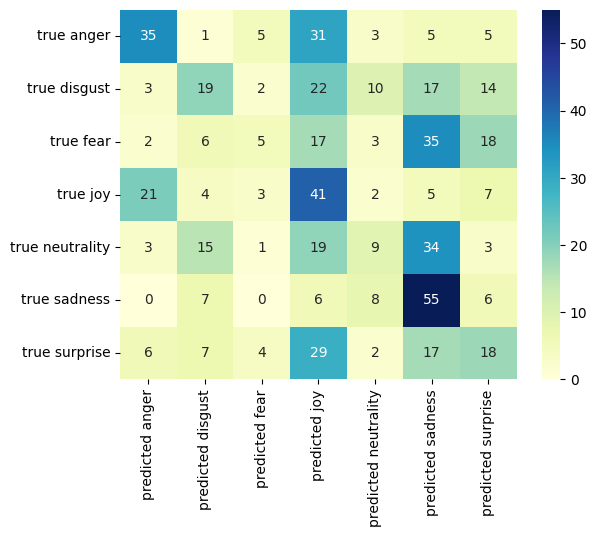

In [21]:
create_confusion_matrix(confusion_matrix(actual_labels_cnn, predicted_labels_cnn))

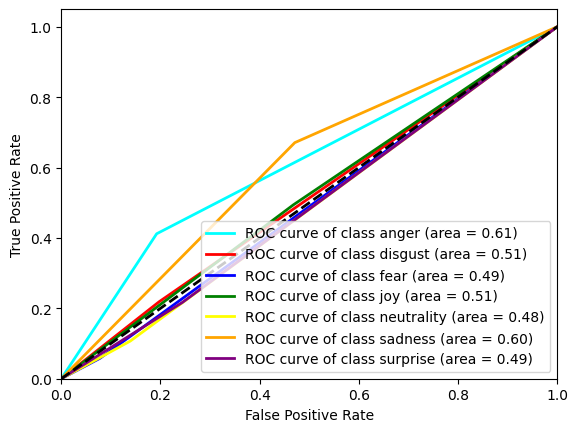

None


,precision,recall,f1
anger,0.500000,0.411765,0.451613
disgust,0.322034,0.218391,0.260274
fear,0.250000,0.058140,0.094340
joy,0.248485,0.493976,0.330645
neutrality,0.243243,0.107143,0.148760
sadness,0.327381,0.670732,0.440000
surprise,0.253521,0.216867,0.233766


In [22]:
confus= confusion_matrix(actual_labels_cnn, predicted_labels_cnn)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}

pd.DataFrame(data=macro_dictionary)



In [23]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in results_cnn:
  mean+=i[1]

average_accuracy_cnn= mean/10
print(average_accuracy_cnn)

0.30847457647323606


#### only pitch

In [24]:
input_data=(X_logmel_semi_aug.shape[1:])
semi_aug_histories_cnn = []
semi_aug_confusion_matrices_cnn=[]
semi_aug_results_cnn=[]
semi_aug_actual_labels_cnn=np.array([])
semi_aug_predicted_labels_cnn=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_logmel_semi_aug, Y_semi_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
            # get the training and test data
            train_X, test_X = X_logmel_semi_aug[train_indices], X_logmel_semi_aug[test_indices]
            train_y, test_y = Y_semi_aug[train_indices], Y_semi_aug[test_indices]
            semi_aug_actual_labels_cnn=np.append(semi_aug_actual_labels_cnn,test_y)
            #normalize the data
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
            test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
            print(train_X.shape)
            modelcnn=create_cnn(input_data)
            modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=256,epochs=1000,callbacks=[EarlyStopping(patience=15,monitor="loss")])
            semi_aug_histories_cnn.append(history)
            pred=modelcnn.predict(test_X)
            pred=pred.argmax(axis=1)
            semi_aug_predicted_labels_cnn=np.append(semi_aug_predicted_labels_cnn,pred)
            conf_matr=confusion_matrix(test_y,pred)
            semi_aug_confusion_matrices_cnn.append(conf_matr)
            results = modelcnn.evaluate(test_X, test_y, batch_size=128)
            semi_aug_results_cnn.append(results)
            

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

(1587, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 372ms/step - accuracy: 0.1547 - loss: 2.5992 - val_accuracy: 0.2429 - val_loss: 2.5360
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 326ms/step - accuracy: 0.2199 - loss: 2.4832 - val_accuracy: 0.1864 - val_loss: 2.4595
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.2127 - loss: 2.4085 - val_accuracy: 0.2542 - val_loss: 2.4166
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 389ms/step - accuracy: 0.2418 - loss: 2.3508 - val_accuracy: 0.2768 - val_loss: 2.3628
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.2409 - loss: 2.3081 - val_accuracy: 0.2599 - val_loss: 2.3345
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.2495 - loss: 2.2436 - val_accuracy: 0.2938 - val_loss: 2.2723
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.2592 - loss: 2.2035 - val_accuracy: 0.2768 - val_loss: 2.2431
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.2573 - loss: 2.1762 - val_accuracy: 0.2825 - val_lo

Computing k-fold:  10%|█         | 1/10 [06:44<1:00:41, 404.66s/it]

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 378ms/step - accuracy: 0.1589 - loss: 2.6134 - val_accuracy: 0.1921 - val_loss: 2.5392
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.2034 - loss: 2.4970 - val_accuracy: 0.1977 - val_loss: 2.4798
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.2373 - loss: 2.4125 - val_accuracy: 0.2599 - val_loss: 2.3985
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 412ms/step - accuracy: 0.2421 - loss: 2.3398 - val_accuracy: 0.2316 - val_loss: 2.3651
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 395ms/step - accuracy: 0.2305 - loss: 2.2996 - val_accuracy: 0.2486 - val_loss: 2.2935
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.2509 - loss: 2.2514 - val_accuracy: 0.2147 - val_loss: 2.2672
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 422ms/step - accuracy: 0.2501 - loss: 2.2145 - val_accuracy: 0.2542 - val_loss: 2.2153
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.2620 - loss: 2.1773 - val_accuracy: 0.

Computing k-fold:  20%|██        | 2/10 [18:09<1:15:54, 569.30s/it]

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 351ms/step - accuracy: 0.1506 - loss: 2.6133 - val_accuracy: 0.2542 - val_loss: 2.5379
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 320ms/step - accuracy: 0.2138 - loss: 2.4856 - val_accuracy: 0.2429 - val_loss: 2.4340
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 337ms/step - accuracy: 0.2285 - loss: 2.4070 - val_accuracy: 0.2938 - val_loss: 2.4047
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - accuracy: 0.2320 - loss: 2.3416 - val_accuracy: 0.2599 - val_loss: 2.3471
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.2381 - loss: 2.2919 - val_accuracy: 0.2429 - val_loss: 2.3073
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.2519 - loss: 2.2423 - val_accuracy: 0.2542 - val_loss: 2.2445
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 405ms/step - accuracy: 0.2483 - loss: 2.2221 - val_accuracy: 0.2994 - val_loss: 2.2167
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.2466 - loss: 2.1693 - val_accuracy: 0.

Computing k-fold:  30%|███       | 3/10 [24:42<57:02, 488.88s/it]  

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 359ms/step - accuracy: 0.1375 - loss: 2.6186 - val_accuracy: 0.2260 - val_loss: 2.5408
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.1877 - loss: 2.5085 - val_accuracy: 0.2542 - val_loss: 2.4640
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 390ms/step - accuracy: 0.2289 - loss: 2.4036 - val_accuracy: 0.2542 - val_loss: 2.3881
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.2405 - loss: 2.3191 - val_accuracy: 0.2203 - val_loss: 2.3519
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 386ms/step - accuracy: 0.2428 - loss: 2.2791 - val_accuracy: 0.2429 - val_loss: 2.2975
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.2604 - loss: 2.2153 - val_accuracy: 0.2655 - val_loss: 2.2494
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 322ms/step - accuracy: 0.2663 - loss: 2.1619 - val_accuracy: 0.2316 - val_loss: 2.2047
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.2503 - loss: 2.1370 - val_accuracy: 0.

Computing k-fold:  40%|████      | 4/10 [36:12<56:50, 568.47s/it]

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 387ms/step - accuracy: 0.1619 - loss: 2.6146 - val_accuracy: 0.2034 - val_loss: 2.5341
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 374ms/step - accuracy: 0.2086 - loss: 2.5045 - val_accuracy: 0.2486 - val_loss: 2.4447
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.2337 - loss: 2.3936 - val_accuracy: 0.2373 - val_loss: 2.3956
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.2179 - loss: 2.3524 - val_accuracy: 0.2147 - val_loss: 2.3595
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.2272 - loss: 2.3107 - val_accuracy: 0.2881 - val_loss: 2.2899
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 381ms/step - accuracy: 0.2401 - loss: 2.2676 - val_accuracy: 0.2881 - val_loss: 2.2696
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.2378 - loss: 2.2123 - val_accuracy: 0.2373 - val_loss: 2.2064
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 378ms/step - accuracy: 0.2576 - loss: 2.1741 - val_accuracy: 0.

Computing k-fold:  50%|█████     | 5/10 [46:17<48:28, 581.60s/it]

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 361ms/step - accuracy: 0.1514 - loss: 2.6105 - val_accuracy: 0.1977 - val_loss: 2.5407
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 397ms/step - accuracy: 0.1835 - loss: 2.5071 - val_accuracy: 0.2260 - val_loss: 2.4457
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step - accuracy: 0.2385 - loss: 2.4035 - val_accuracy: 0.2316 - val_loss: 2.3728
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.2310 - loss: 2.3356 - val_accuracy: 0.2373 - val_loss: 2.3313
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.2354 - loss: 2.2927 - val_accuracy: 0.2825 - val_loss: 2.2854
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.2570 - loss: 2.2388 - val_accuracy: 0.2655 - val_loss: 2.2467
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 388ms/step - accuracy: 0.2525 - loss: 2.2019 - val_accuracy: 0.2768 - val_loss: 2.2073
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.2790 - loss: 2.1510 - val_accuracy: 0.

Computing k-fold:  60%|██████    | 6/10 [55:06<37:34, 563.57s/it]

(1587, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 400ms/step - accuracy: 0.1541 - loss: 2.6144 - val_accuracy: 0.2090 - val_loss: 2.5429
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.2305 - loss: 2.4953 - val_accuracy: 0.1977 - val_loss: 2.4654
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 527ms/step - accuracy: 0.2295 - loss: 2.4059 - val_accuracy: 0.1921 - val_loss: 2.3963
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.2387 - loss: 2.3580 - val_accuracy: 0.2655 - val_loss: 2.3626
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 513ms/step - accuracy: 0.2432 - loss: 2.3054 - val_accuracy: 0.2429 - val_loss: 2.3240
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 502ms/step - accuracy: 0.2289 - loss: 2.2543 - val_accuracy: 0.2316 - val_loss: 2.2558
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 866ms/step - accuracy: 0.2417 - loss: 2.2178 - val_accuracy: 0.2429 - val_loss: 2.2347
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - accuracy: 0.2476 - loss: 2.1733 - val_accuracy: 0.2542 - val_lo

Computing k-fold:  70%|███████   | 7/10 [1:10:47<34:20, 686.89s/it]

(1587, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 442ms/step - accuracy: 0.1426 - loss: 2.6109 - val_accuracy: 0.1751 - val_loss: 2.5451
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 598ms/step - accuracy: 0.1933 - loss: 2.5239 - val_accuracy: 0.1864 - val_loss: 2.4660
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 0.2020 - loss: 2.4390 - val_accuracy: 0.2599 - val_loss: 2.3808
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.2150 - loss: 2.3550 - val_accuracy: 0.2429 - val_loss: 2.3389
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.2227 - loss: 2.3047 - val_accuracy: 0.2881 - val_loss: 2.2824
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.2386 - loss: 2.2463 - val_accuracy: 0.3051 - val_loss: 2.2250
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.2351 - loss: 2.1915 - val_accuracy: 0.2825 - val_loss: 2.1899
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 543ms/step - accuracy: 0.2526 - loss: 2.1676 - val_accuracy: 0.2486 - val_lo

Computing k-fold:  80%|████████  | 8/10 [1:22:40<23:10, 695.24s/it]

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 531ms/step - accuracy: 0.1560 - loss: 2.6201 - val_accuracy: 0.1864 - val_loss: 2.5316
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 479ms/step - accuracy: 0.2039 - loss: 2.4872 - val_accuracy: 0.2034 - val_loss: 2.4430
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.2206 - loss: 2.3948 - val_accuracy: 0.2825 - val_loss: 2.3827
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 448ms/step - accuracy: 0.2312 - loss: 2.3426 - val_accuracy: 0.3390 - val_loss: 2.3278
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 433ms/step - accuracy: 0.2233 - loss: 2.2803 - val_accuracy: 0.2768 - val_loss: 2.2736
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.2202 - loss: 2.2690 - val_accuracy: 0.2881 - val_loss: 2.2679
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 498ms/step - accuracy: 0.2422 - loss: 2.2095 - val_accuracy: 0.3107 - val_loss: 2.1810
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.2397 - loss: 2.1600 - val_accuracy: 0.

Computing k-fold:  90%|█████████ | 9/10 [1:32:43<11:06, 666.59s/it]

(1587, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 532ms/step - accuracy: 0.1528 - loss: 2.6057 - val_accuracy: 0.2486 - val_loss: 2.5353
Epoch 2/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.2244 - loss: 2.5012 - val_accuracy: 0.2881 - val_loss: 2.4229
Epoch 3/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 459ms/step - accuracy: 0.2213 - loss: 2.4206 - val_accuracy: 0.2768 - val_loss: 2.3756
Epoch 4/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 446ms/step - accuracy: 0.2129 - loss: 2.3584 - val_accuracy: 0.3107 - val_loss: 2.3201
Epoch 5/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - accuracy: 0.2244 - loss: 2.2910 - val_accuracy: 0.2825 - val_loss: 2.2676
Epoch 6/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 441ms/step - accuracy: 0.2519 - loss: 2.2392 - val_accuracy: 0.2825 - val_loss: 2.2356
Epoch 7/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 467ms/step - accuracy: 0.2381 - loss: 2.2120 - val_accuracy: 0.3107 - val_loss: 2.2050
Epoch 8/1000
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - accuracy: 0.2637 - loss: 2.1525 - val_accuracy: 0.

<Axes: >

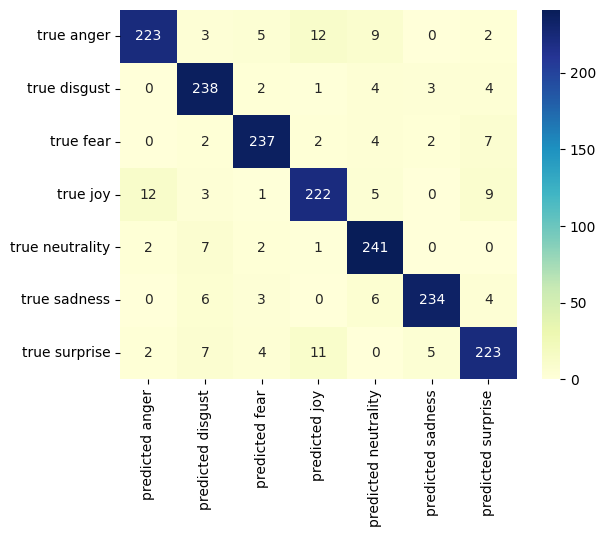

In [25]:
create_confusion_matrix(confusion_matrix(semi_aug_actual_labels_cnn, semi_aug_predicted_labels_cnn))

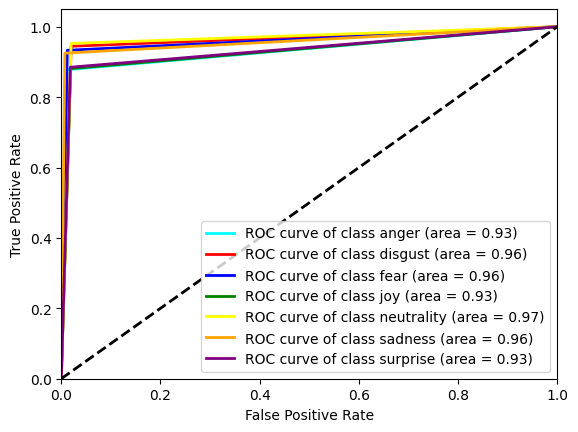

None


,precision,recall,f1
anger,0.933054,0.877953,0.904665
disgust,0.894737,0.944444,0.918919
fear,0.933071,0.933071,0.933071
joy,0.891566,0.880952,0.886228
neutrality,0.895911,0.952569,0.923372
sadness,0.959016,0.924901,0.941650
surprise,0.895582,0.884921,0.890220


In [26]:
confus= confusion_matrix(semi_aug_actual_labels_cnn, semi_aug_predicted_labels_cnn)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [27]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in semi_aug_results_cnn:
  mean+=i[1]

semi_aug_average_accuracy_cnn= mean/10
print(semi_aug_average_accuracy_cnn)

0.9141242921352386


#### All dataset

In [28]:
input_data=(X_logmel_aug.shape[1:])
aug_histories_cnn = []
aug_confusion_matrices_cnn=[]
aug_results_cnn=[]
aug_actual_labels_cnn=np.array([])
aug_predicted_labels_cnn=np.array([])
for split_n, (train_indices, test_indices) in tqdm(
            enumerate(generator.split(X_logmel_aug, Y_aug)),
            total=10,
            leave=False,
            desc="Computing k-fold"
        ):
            # get the training and test data
            train_X, test_X = X_logmel_aug[train_indices], X_logmel_aug[test_indices]
            train_y, test_y = Y_aug[train_indices], Y_aug[test_indices]
            aug_actual_labels_cnn=np.append(aug_actual_labels_cnn,test_y)
            #normalize the data
            scaler = StandardScaler()
            train_X = scaler.fit_transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
            test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
            print(train_X.shape)
            modelcnn=create_cnn(input_data)
            modelcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = modelcnn.fit(train_X, train_y, validation_data=(test_X,test_y), batch_size=256,epochs=1000,callbacks=[EarlyStopping(patience=20,monitor="loss")])
            aug_histories_cnn.append(history)
            pred=modelcnn.predict(test_X)
            pred=pred.argmax(axis=1)
            aug_predicted_labels_cnn=np.append(aug_predicted_labels_cnn,pred)
            conf_matr=confusion_matrix(test_y,pred)
            aug_confusion_matrices_cnn.append(conf_matr)
            results = modelcnn.evaluate(test_X, test_y, batch_size=128)
            aug_results_cnn.append(results)
  

Computing k-fold:   0%|          | 0/10 [00:00<?, ?it/s]

(2116, 60, 130, 1)


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 417ms/step - accuracy: 0.1557 - loss: 2.6097 - val_accuracy: 0.2288 - val_loss: 2.5233
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 487ms/step - accuracy: 0.2221 - loss: 2.4635 - val_accuracy: 0.2500 - val_loss: 2.4093
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 512ms/step - accuracy: 0.2151 - loss: 2.3906 - val_accuracy: 0.2500 - val_loss: 2.3802
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 463ms/step - accuracy: 0.2307 - loss: 2.3190 - val_accuracy: 0.2331 - val_loss: 2.2844
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.2428 - loss: 2.2381 - val_accuracy: 0.2669 - val_loss: 2.2495
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 486ms/step - accuracy: 0.2479 - loss: 2.2004 - val_accuracy: 0.2458 - val_loss: 2.1816
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 445ms/step - accuracy: 0.2514 - loss: 2.1529 - val_accuracy: 0.2585 - val_loss: 2.1540
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 443ms/step - accuracy: 0.2413 - loss: 2.1095 - val_accuracy: 0.

Computing k-fold:  10%|█         | 1/10 [14:55<2:14:23, 895.92s/it]

(2116, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 392ms/step - accuracy: 0.1426 - loss: 2.6206 - val_accuracy: 0.2119 - val_loss: 2.5213
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 372ms/step - accuracy: 0.2012 - loss: 2.4645 - val_accuracy: 0.2669 - val_loss: 2.3969
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 368ms/step - accuracy: 0.2396 - loss: 2.3522 - val_accuracy: 0.2669 - val_loss: 2.3531
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 376ms/step - accuracy: 0.2404 - loss: 2.3051 - val_accuracy: 0.2797 - val_loss: 2.2906
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 373ms/step - accuracy: 0.2560 - loss: 2.2369 - val_accuracy: 0.2839 - val_loss: 2.2325
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.2504 - loss: 2.1787 - val_accuracy: 0.2288 - val_loss: 2.2031
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 390ms/step - accuracy: 0.2555 - loss: 2.1404 - val_accuracy: 0.2754 - val_loss: 2.1304
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 0.2635 - loss: 2.0758 - val_accuracy: 0.2754 - val_lo

Computing k-fold:  20%|██        | 2/10 [30:55<2:04:25, 933.21s/it]

(2116, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 459ms/step - accuracy: 0.1498 - loss: 2.6314 - val_accuracy: 0.2161 - val_loss: 2.5304
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.2226 - loss: 2.4783 - val_accuracy: 0.2161 - val_loss: 2.4162
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 406ms/step - accuracy: 0.2267 - loss: 2.3745 - val_accuracy: 0.2627 - val_loss: 2.3805
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.2381 - loss: 2.3213 - val_accuracy: 0.2585 - val_loss: 2.3063
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 457ms/step - accuracy: 0.2427 - loss: 2.2620 - val_accuracy: 0.2669 - val_loss: 2.2618
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 518ms/step - accuracy: 0.2503 - loss: 2.1992 - val_accuracy: 0.2542 - val_loss: 2.2177
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 477ms/step - accuracy: 0.2554 - loss: 2.1497 - val_accuracy: 0.2712 - val_loss: 2.1669
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 434ms/step - accuracy: 0.2662 - loss: 2.1183 - val_accuracy: 0.2924 - val_lo

Computing k-fold:  30%|███       | 3/10 [47:18<1:51:30, 955.86s/it]

(2116, 60, 130, 1)
Epoch 1/1000


c:\Users\anton\Documents\PhD\Speech_Emotion_Recognition\EMOVO_dataset\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 382ms/step - accuracy: 0.1759 - loss: 2.5868 - val_accuracy: 0.1907 - val_loss: 2.5041
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 414ms/step - accuracy: 0.2154 - loss: 2.4459 - val_accuracy: 0.2246 - val_loss: 2.4257
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 410ms/step - accuracy: 0.2279 - loss: 2.3614 - val_accuracy: 0.2500 - val_loss: 2.3551
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 396ms/step - accuracy: 0.2440 - loss: 2.2656 - val_accuracy: 0.2415 - val_loss: 2.3027
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 395ms/step - accuracy: 0.2346 - loss: 2.2184 - val_accuracy: 0.2288 - val_loss: 2.2391
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 394ms/step - accuracy: 0.2432 - loss: 2.1774 - val_accuracy: 0.2161 - val_loss: 2.2026
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - accuracy: 0.2643 - loss: 2.1221 - val_accuracy: 0.2585 - val_loss: 2.1494
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 397ms/step - accuracy: 0.2608 - loss: 2.0785 - val_accuracy: 0.2415 - val_lo

In [ ]:
create_confusion_matrix(confusion_matrix(aug_actual_labels_cnn, aug_predicted_labels_cnn))

In [ ]:
confus= confusion_matrix(aug_actual_labels_cnn, aug_predicted_labels_cnn)
pr,rec,f1,fpr=calculate_scores(confus)
print(create_general_roc_curve(fpr,rec))
for i in range(7):
  pr[sorted_labels[i]] = pr.pop(i)
  rec[sorted_labels[i]] = rec.pop(i)
  f1[sorted_labels[i]] = f1.pop(i)
macro_dictionary={'precision': pr , 'recall': rec,'f1':f1}
pd.DataFrame(data=macro_dictionary)

In [ ]:
#calculate the average of the accuracies obtained in the iterations
mean= 0.0
for i in aug_results_cnn:
  mean+=i[1]

aug_average_accuracy_cnn= mean/10
print(aug_average_accuracy_cnn)